In [1]:
import numpy as np
import pandas as pd 
import random

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp

In [29]:
#random.seed(24)

n=1000

sim = 10000

a = 1
b = 1
p=0.9

In [3]:
class dataset:
    def __init__(self,n,p,df):
        #Number of observations
        self.n = n
        #MCAR Bernoulli prob.
        self.p = p
        #data set 
        self.df = df 
        
    #Ishigami function
        #np.random.seed(24)   
    
    def ishigami(self):
        return lambda a, b:  np.sin(self.df['X1']) + a * np.sin(self.df['X2'])**2 + b * (self.df['X3'])**4 * np.sin(self.df['X1']) + np.random.normal(0, 0.01, self.n)
    
    def toyreg(self):
        return lambda b1,b2: b1*self.df['X1'] + b2*self.df['X2'] + np.random.normal(0, 0.01, self.n)
    
    #H-Sample with target from Ishigami function
    
    def h_df(self,a,b):
        self.df['Y'] = self.ishigami()(a,b)
        return self.df['Y']
    
    def picked(self,request,a,b):
        #request are the variables to be randomized, e.g. ['X2','X3']
        newdf = self.df.copy()
        values  = [list(pd.Series(np.random.uniform(0,1,self.n)))]*len(request)
        dictionary = dict(zip(request, values))
        for col, new_values in dictionary.items():
            newdf = newdf.assign(**{col: new_values})
        return newdf
    
    def mcar(self,a,b):
        #self.df['Y'] = self.ishigami()(a,b)
        mask = np.random.binomial(size=(self.n,3), n=1, p= self.p) == 1
        mask = np.reshape(mask,(self.n,3))
        #print(mask)
        df1 = self.df.where(mask,np.nan)
        #print(df1)
        return df1.dropna()
    
    def mar(self,cond1,cond2):
        cond_x = np.where((self.df['X1'] <0.5) , 1, 0) # & or (self.df['X3'] <0.1)
        omega = (np.random.binomial(size=(self.n,1), n=1, p= p) == 1)  #omega.shape 
        omega = np.reshape(omega,(self.n,))
        condition = (omega & (cond_x  ==1)) | (cond_x  ==0)
        self.df['X3'] = np.where(condition,np.array(self.df['X3']),np.nan)
        return self.df.dropna()
    
    
    
    

In [4]:
df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
#df['Y'] = dataset(n,p,df).ishigami()(a,b)
#df

In [5]:
cc = dataset(n,p,df).mcar(a,b)
#cc

In [6]:
def sobol(request,sim):
    sobol_list = []
    for x in range(sim):
        df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
        newdf   = dataset(n,p,df).picked(request,a,b)
        df['Y']    = dataset(n,p,df).h_df(a,b)
        newdf['Y'] = dataset(n,p,newdf).h_df(a,b)
        sobol_list.append((np.cov(df.Y,newdf.Y)/np.var(df.Y))[0][1])
    return sobol_list

Text(0.5, 1.0, '')

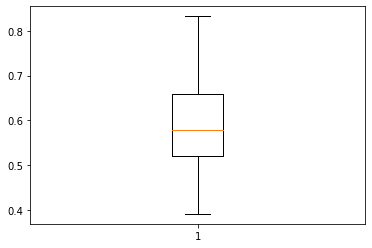

In [7]:
#singletons H-Sample
sobol_X1 = sobol(['X2','X3'],sim)
sobol_X2 = sobol(['X1','X3'],sim)
sobol_X3 = sobol(['X1','X3'],sim)
plt.boxplot(sobol_X1)
plt.title('')

[Text(1, 0, 'X1'), Text(2, 0, 'X2'), Text(3, 0, 'X3')]

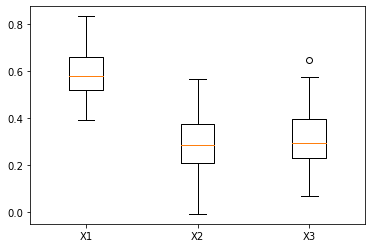

In [8]:
singletons = dict(zip(['X1','X2','X3'],[sobol_X1,sobol_X2,sobol_X3]))

fig, ax = plt.subplots()
ax.boxplot(singletons.values())
ax.set_xticklabels(singletons.keys())


In [9]:
df_singletons = pd.DataFrame(singletons)
#sns.violinplot(data=df_singletons)

In [10]:
def sobol_mis(request,sim):
    sobol_list = []
    for x in range(sim):
        df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
        cc = dataset(n,p,df).mcar(a,b)
        cc['Y'] = dataset(len(cc),p,cc).h_df(a,b)
        newcc   = dataset(len(cc),p,cc).picked(request,a,b)
        newcc['Y'] = dataset(len(cc),p,newcc).h_df(a,b)
        sobol_list.append((np.cov(cc.Y,newcc.Y)/np.var(cc.Y))[0][1])
    return sobol_list

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7c0f2021f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7c0f2028e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7c0f1f6e50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7c0f202fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7c0f20f340>],
 'means': []}

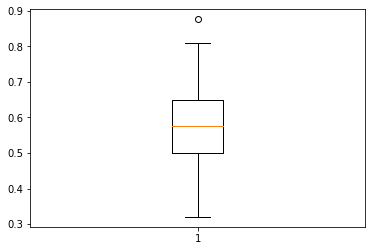

In [11]:
#singletons test 
sobol_X1_mis = sobol_mis(['X2','X3'],sim)
sobol_X2_mis = sobol_mis(['X1','X3'],sim)
sobol_X3_mis = sobol_mis(['X1','X3'],sim)
plt.boxplot(sobol_X1_mis)

In [12]:
singletons_mis = dict(zip(['X1','X2','X3'],[sobol_X1_mis,sobol_X2_mis,sobol_X3_mis]))

[Text(1, 0, 'X1'), Text(2, 0, 'X2'), Text(3, 0, 'X3')]

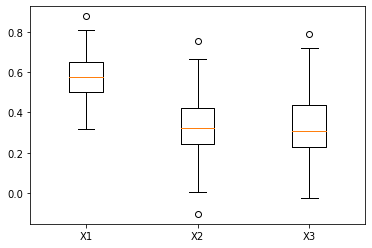

In [13]:
fig, ax = plt.subplots()
ax.boxplot(singletons_mis.values())

ax.set_xticklabels(singletons_mis.keys())

<AxesSubplot:>

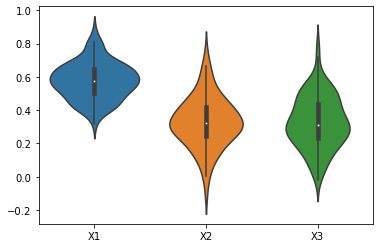

In [14]:
df_singletons_mis = pd.DataFrame(singletons_mis)

sns.violinplot(data=df_singletons_mis)

In [15]:
df_singletons_mis['sample'] = 'cc'
df_singletons['sample'] = 'complete'


cdf = pd.concat([df_singletons, df_singletons_mis],axis=0)  

In [16]:
dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1','X2','X3'],var_name='Variable')

#dd

dd = dd.rename(columns={'value':'Sobol index'})

In [17]:
dd.describe()

,Sobol index
count,600.000000
mean,0.403872
std,0.179685
min,-0.102410
25%,0.264688
50%,0.400559
75%,0.542139
max,0.876518


[(0.0, 1.0)]

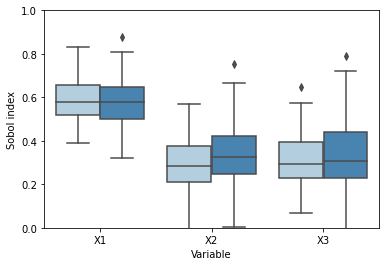

In [28]:
ax =sns.boxplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")
ax.legend_.remove()
ax.set(ylim=(0, 1))


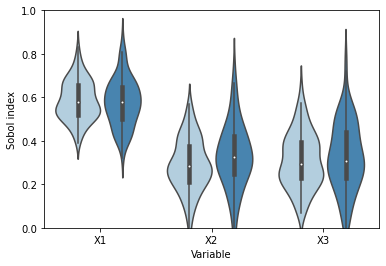

In [19]:
ax = sns.violinplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")

ax.legend_.remove()

fig = ax.get_figure()
ax.set(ylim=(0, 1))
fig.savefig('violin_cc_true.pdf',transparent=True,bbox_inches='tight')

In [20]:
def sobolplot(n,sim,p):
    sobol_X1 = sobol(['X2','X3'],sim)
    sobol_X2 = sobol(['X1','X3'],sim)
    sobol_X3 = sobol(['X1','X3'],sim)
    singletons = dict(zip(['X1','X2','X3'],[sobol_X1,sobol_X2,sobol_X3]))
    df_singletons = pd.DataFrame(singletons)
    df_singletons['sample'] = 'complete'
    #Missings
    sobol_X1_mis = sobol_mis(['X2','X3'],sim)
    sobol_X2_mis = sobol_mis(['X1','X3'],sim)
    sobol_X3_mis = sobol_mis(['X1','X3'],sim)
    singletons_mis = dict(zip(['X1','X2','X3'],[sobol_X1_mis,sobol_X2_mis,sobol_X3_mis]))
    df_singletons_mis = pd.DataFrame(singletons_mis)
    df_singletons_mis['sample'] = 'cc'
    #Merge
    cdf = pd.concat([df_singletons, df_singletons_mis],axis=0)  
    dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1','X2','X3'],var_name='Variable')
    dd = dd.rename(columns={'value':'Sobol index'})
    dd.to_csv('Sobol singleton for p='+str(p)+'.csv')  
    ax = sns.boxplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues") #,showfliers=False
    #ax = sns.violinplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")
    ax.legend_.remove()
    ax.set(ylim=(0.15, 0.7))
    fig = ax.get_figure()
    fig.savefig('images/violin_cc_true for p='+str(p)+'.pdf',transparent=True,bbox_inches='tight')
    return fig
    

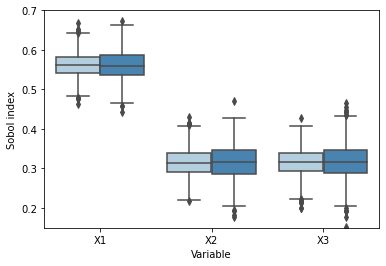

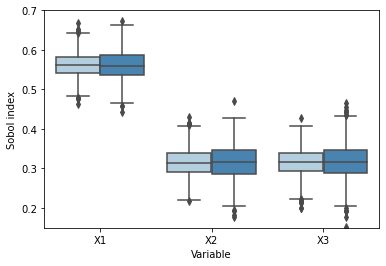

In [21]:
n = 1000
sim = 1000
sobolplot(n,sim,0.9)

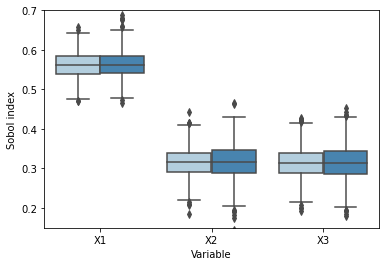

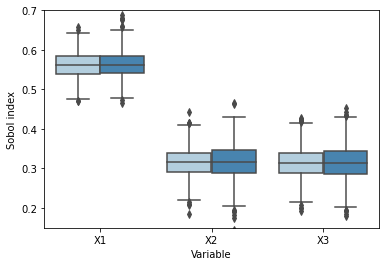

In [22]:
sobolplot(n,sim,0.75)

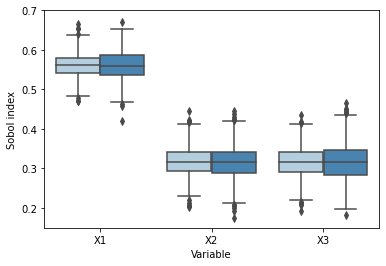

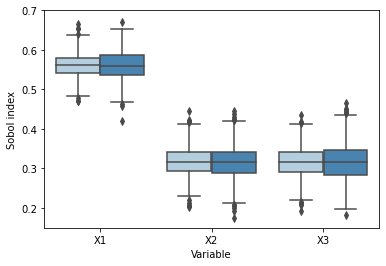

In [23]:
sobolplot(n,sim,0.4)

In [24]:
for p in [0.4,0.75,0.9]: #
    print('Test for p='+str(p))
    ddp = pd.read_csv('Sobol singleton for p='+str(p)+'.csv')
    for x in ['X1','X2','X3']:
        sobol1 = ddp.loc[(ddp['Variable'] ==x) & (ddp['sample']=='complete')]['Sobol index']
        sobolcc= ddp.loc[(ddp['Variable'] ==x) & (ddp['sample']=='cc')]['Sobol index']
        print(ks_2samp(sobol1,sobolcc))

Test for p=0.4
KstestResult(statistic=0.063, pvalue=0.03776014017220749)
KstestResult(statistic=0.044, pvalue=0.28779764348473313)
KstestResult(statistic=0.063, pvalue=0.03776014017220749)
Test for p=0.75
KstestResult(statistic=0.032, pvalue=0.6854967337920594)
KstestResult(statistic=0.076, pvalue=0.006185603570160095)
KstestResult(statistic=0.058, pvalue=0.06917625399020766)
Test for p=0.9
KstestResult(statistic=0.072, pvalue=0.01118990326412112)
KstestResult(statistic=0.061, pvalue=0.04839715079181246)
KstestResult(statistic=0.06, pvalue=0.05462666510701526)


In [25]:
ddp09 = pd.read_csv('Sobol singleton for p=0.9.csv')

sobol_complete = ddp09.loc[(ddp09['Variable']=='X1') & (ddp09['sample']=='complete')].sort_values('Sobol index')

ddp09.loc[(ddp09['Variable']=='X1') & (ddp09['sample']=='complete')].describe()

,Unnamed: 0,Sobol index
count,1000.000000,1000.000000
mean,499.500000,0.560410
std,288.819436,0.031214
min,0.000000,0.463884
25%,249.750000,0.540431
50%,499.500000,0.560576
75%,749.250000,0.581336
max,999.000000,0.668363


In [26]:
sobol_cc = ddp09.loc[(ddp09['Variable']=='X1') & (ddp09['sample']=='cc')].sort_values('Sobol index')

ddp09.loc[(ddp09['Variable']=='X1') & (ddp09['sample']=='cc')].describe()

,Unnamed: 0,Sobol index
count,1000.000000,1000.000000
mean,1499.500000,0.561641
std,288.819436,0.037408
min,1000.000000,0.443482
25%,1249.750000,0.536062
50%,1499.500000,0.558660
75%,1749.250000,0.587500
max,1999.000000,0.674239


In [27]:
ks_2samp(sobol_complete['Sobol index'][100:990],sobol_cc['Sobol index'][100:990])

KstestResult(statistic=0.08089887640449438, pvalue=0.005889052050338807)